In [1]:
from segment_anything import sam_model_registry, SamPredictor
import urllib
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
import cv2
import glob

from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

In [2]:
def setup_segment_anything_model(model_type="vit_b", device="cuda"):
    # get model checkpoint
    checkpoint_mapping = {
        "vit_h": "sam_vit_h_4b8939.pth",
        "vit_l": "sam_vit_l_0b3195.pth",
        "vit_b": "sam_vit_b_01ec64.pth"
    }
    sam_checkpoint = checkpoint_mapping.get(model_type)
    if sam_checkpoint is None:
        raise ValueError(f"Invalid model_type: {model_type}")
    checkpoint_url = f"https://dl.fbaipublicfiles.com/segment_anything/{sam_checkpoint}"
    urllib.request.urlretrieve(checkpoint_url, sam_checkpoint)
    # initiate the model
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    return sam
# set up SAM
sam = setup_segment_anything_model(model_type="vit_b", device="cuda")
# set default parameters for the mask predictor
predictor = SamPredictor(sam)

In [51]:
def predict_masks(predictor, img, bounding_boxes = None, input_points = None, input_labels = None):
    with torch.no_grad():
        # Make image embedding
        predictor.set_image(img)

        # Feed bounding boxes (and center points) to mask predictor

        if input_points is not None:
            input_points_tensor = torch.tensor(input_points, device=predictor.device)
            input_labels_tensor = torch.tensor(input_labels, device=predictor.device)
            transformed_points = predictor.transform.apply_coords_torch(input_points_tensor, img.shape[:2])
        else:
            transformed_points = None

        if bounding_boxes is not None:
            input_boxes = torch.tensor(bounding_boxes, device=predictor.device)
            transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, img.shape[:2])
        else:
            transformed_boxes = None
        masks, _, _ = predictor.predict_torch(
            point_coords=transformed_points,
            point_labels=input_labels_tensor,
            # point_coords=None,
            # point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
    return masks

In [52]:
num_inferences = 100
filenames = glob.glob("*.png")

grand_total_time = 0
for image_path in filenames:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    total_time = 0
    for i in tqdm(range(num_inferences)):
        x_coord = np.random.randint(image.shape[0])
        y_coord = np.random.randint(image.shape[1])

        start_time = time.time()
        predicted_masks = predict_masks(predictor, image, input_points = [[[x_coord, y_coord]]], input_labels = [[1]])    
        end_time = time.time()

        total_time += (end_time - start_time)

    average_inference_time = total_time / num_inferences
    grand_total_time += total_time

    print(f"Average inference time for {num_inferences} inferences on {image_path}: {average_inference_time:.4f} seconds")

print(f"Average inference time for all {num_inferences*len(filenames)} inferences: {grand_total_time/(num_inferences*len(filenames)):.4f} seconds")
    

100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


Average inference time for 100 inferences on tableside_image_1.png: 0.0943 seconds


100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


Average inference time for 100 inferences on precut_image_1.png: 0.0950 seconds


100%|██████████| 100/100 [00:09<00:00, 10.49it/s]

Average inference time for 100 inferences on assembly_image_0.png: 0.0950 seconds
Average inference time for all 300 inferences: 0.0947 seconds


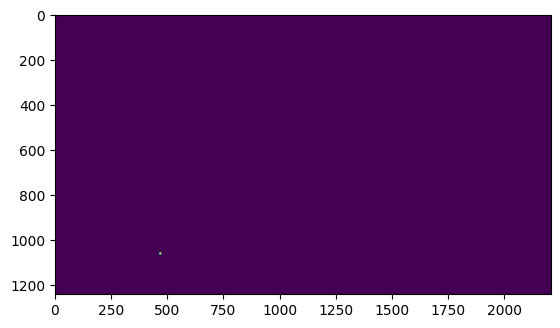

In [53]:
plt.imshow(predicted_masks.cpu().detach().numpy().squeeze())